# Homework 2: Convolutional Neural Networks in PyTorch

In [1]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch
import torchvision
from torchviz import make_dot

First, lets take a look at the AlexNet architecture, which demonstrated the amazing effectiveness of convolutional neural networks in image classification. The following cell loads the architecture itself, without loading any pre-trained parameters.

In [3]:
alexnet = torchvision.models.alexnet(weights=None)

In [4]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
layer_info = {}

# Register hook to each layer
def hook_fn(module, input, output):
    layer_info[str(module)+str(tuple(input[0].size()))] = {
        'input_shape': tuple(input[0].size()), 
        'output_shape': tuple(output.size()),
        'param_count': sum(p.numel() for p in module.parameters() if p.requires_grad)
    }
    
# Register hook to each layer
for layer in alexnet.modules():
    layer.register_forward_hook(hook_fn)

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224)

# Perform a forward pass
alexnet(dummy_input)

# Display the output shapes
for layer, info in layer_info.items():
    print(f"layer: {layer}:")
    print(f"  Input Shape: {info['input_shape']}")
    print(f"  Output Shape: {info['output_shape']}")
    print(f"  Parameter Count: {info['param_count']}")
    print('='*50)

layer: Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))(1, 3, 224, 224):
  Input Shape: (1, 3, 224, 224)
  Output Shape: (1, 64, 55, 55)
  Parameter Count: 23296
layer: ReLU(inplace=True)(1, 64, 55, 55):
  Input Shape: (1, 64, 55, 55)
  Output Shape: (1, 64, 55, 55)
  Parameter Count: 0
layer: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)(1, 64, 55, 55):
  Input Shape: (1, 64, 55, 55)
  Output Shape: (1, 64, 27, 27)
  Parameter Count: 0
layer: Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(1, 64, 27, 27):
  Input Shape: (1, 64, 27, 27)
  Output Shape: (1, 192, 27, 27)
  Parameter Count: 307392
layer: ReLU(inplace=True)(1, 192, 27, 27):
  Input Shape: (1, 192, 27, 27)
  Output Shape: (1, 192, 27, 27)
  Parameter Count: 0
layer: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)(1, 192, 27, 27):
  Input Shape: (1, 192, 27, 27)
  Output Shape: (1, 192, 13, 13)
  Parameter Count: 0
layer: Conv2d(192,

# Questions:

**1. What is the shape of the input? Explain.**<br>
By this section "dummy_input = torch.randn(1, 3, 224, 224)" we can understand that the shape of the input is (1, 3, 224, 224) <br>
1: The batch size. In this case, it's set to 1, meaning there is one image in the batch.<br>
3: The number of color channels. It's 3 because the input image is in RGB format, which has three color channels (red, green, and blue).<br>
224: These are the spatial dimensions of the image. The image has a width and height of 224 pixels each.<br>
In summary, it's a batch of one image with a size of 224x224 pixels and three color channels.

**2. What is the shape of the output? Explain**<br>
Output Shape: (1, 1000). <br>
1: The output corresponds to one image.<br>
1000: The number of classes in the ImageNet dataset, for which AlexNet was originally designed- each element of this dimension represents the model's confidence score(/"probability") for each class. <br>

**3. What is the shape of the output immediately after the last MaxPool layer in AlexNet? Explain.**<br>
Output Shape: (1, 256, 6, 6) <br>
We can see this both in the output printed above and by hand calculating- for calculate the shape output from each convolutional we can use the formula (the filters number will be the same as define in the code): $\dfrac{\text{Input-Kernel+2*Pad}}{\text{Stride}}+1$
and then each pooling maintains the same number of filters while halving the pixel dimensions both widthwise and lengthwise.
1: The batch size, as before.<br>
256: The number of feature maps (or filters) produced by the last convolutional layer. This indicates the model has learned 256 distinct features at this stage.<br>
6, 6: The spatial dimensions of the feature maps after pooling. The MaxPool layers progressively reduce the size of the feature maps to concentrate the information and reduce computational requirements.<br>

**4. How many parameters does AlexNet have in total? How many parameters are allocated for the "feature extraction" stage and how many for the "classifier" stage? Explain the difference.**<br>
In total: 61,100,840 parameters. <br>
In the "feature extraction" stage: 2,469,696 parameters. <br>
In the "classifier" stage: 58,631,144 parameters. <br>
_The Classifier Stage has almost 24 times more parameters than the Feature Extraction Stage_. <br>
The substantial difference in the number of parameters between the feature extraction and classifier stages of a CNN can be attributed to their distinct functions. The feature extraction stage, composed of convolutional layers, scans parts of the image with filters to detect patterns and features using a modest number of parameters. This allows the network to identify important spatial hierarchies in the image data efficiently. <br>
On the other hand, the classifier stage, typically made up of just a few fully connected layers, requires a significantly larger number of parameters. This is because it performs the complex task of classification based on the features extracted earlier, connecting every neuron to all neurons in the next layer to form a comprehensive understanding that leads to the final decision. <br>
A nice metaphor I found-<br>
while convolutional layers are like detectives that gather clues (features) using specific tools (filters) without much complexity, the classifier stage is like a council that deliberates on those clues to make a final judgment, which is a more parameter-intensive process.

Now we will visualize the weights of the neural network. For simplicity, I will visualize the first layer only.

torch.Size([64, 3, 11, 11])


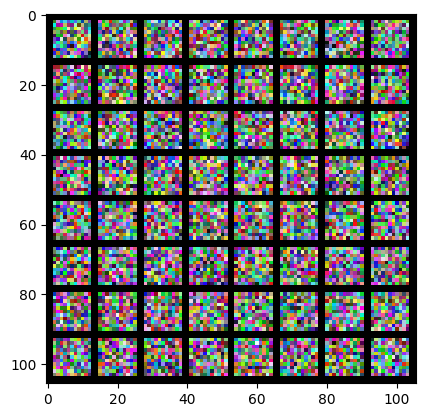

In [6]:
from torchvision.utils import make_grid
kernels = alexnet.features[0].weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)
img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))

Lets load the pretrained weights and visualize both the first layer and the second convoluational layer.

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 3, 11, 11])


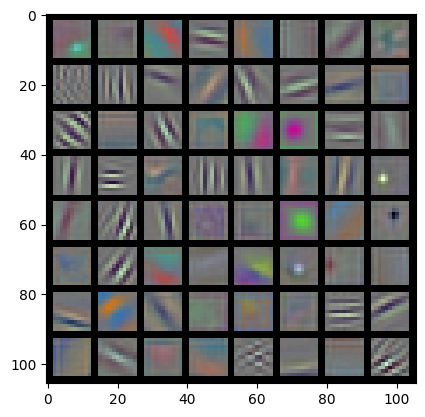

In [7]:
alexnet = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights)
kernels = alexnet.features[0].weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)

img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))

torch.Size([64, 3, 5, 5])


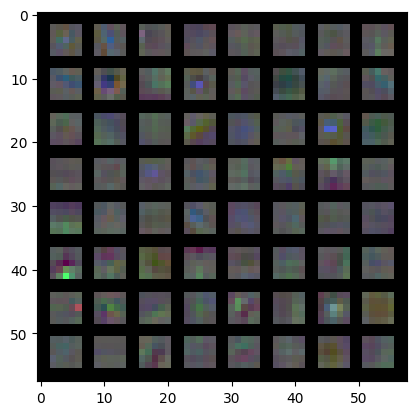

In [8]:
alexnet = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights)
kernels = alexnet.features[3].weight.detach().clone()[:64,:3,:,:]
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)

img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))

# Question:

**1. Why and in what sense do the visualizations of the first layer look "better"?** <br>
The first layer tend to look "better" for a few reasons: the pixcels amount, they have more direct interactions with the input image, subsequent layers build upon the knowledge of previous ones rather than the source image, and deeper layers extract more abstract, complex features that are less intuitive for human comprehension. Hence, these early patterns are more easily understood as they relate to fundamental aspects of visual perception.

# Part 2 - Training a CNN

You will train a convolutional neural network in PyTorch on the CIFAR10 dataset. Try using all the hyperparameters you can think: architectures, number of hidden layers, layer size, dropout, regularization, batch size, optimizer, loss functions and more. Good luck!

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


PyTorch expects images in the format (num_channels, width, height) while plt expects images in a numpy array of shape (width, height, num_channels). `np.transpose` takes as input an array and list of axes, and moves the original axes according to the order that appears in the list. For example, calling `transpose` with some image in the format (c,w,h) and the list (1,2,0) will return the array in the format (w,h,c).

Image shape:  torch.Size([3, 32, 32])
      ship        dog       frog        dog


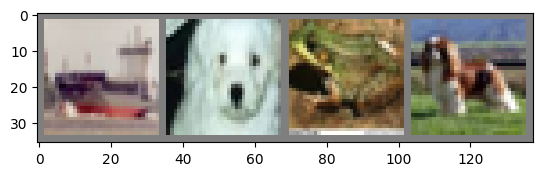

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Define the basic architecture of your network. You can use any combination#
        # of layers.                                                                #
        # In this function, you should only define the layers you intend to use.    #
        # Save each layer as a different *self variable*.                           #
        # This function has no return value.                                        #
        #############################################################################
        #Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2) # Output shape: 8*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output shape: 8*16*16

        #Layer 2:
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1) # Output shape: 16*8*8
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output shape: 16*4*4

        #Layer 3:
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=3, padding=1) # Output shape: 32*1*1
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output shape: 32*1*1

        # Linear Layer
        self.fc = nn.Linear(32*1*1, 10)


    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation of your network. Connect each layer to     #
        # the next and experiment with different activations, number of parameters  #
        # and depths. You can read about different activations in PyTorch at        #
        # https://pytorch.org/docs/stable/nn.html#non-linear-activation-functions   #
        # Return a single tensor after passing it through your network.             #
        # Hint: Shaping a multidimensional tensor into a vector can be achieved by: #
        # the method x.view()                                                       #
        #############################################################################
        #Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        #Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        #Layer 3:
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Fully connected Layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return(x)
        
net = Net()

#############################################################################
# TO DO:                                                                    #
# Pick a loss function and optimizer from your network. Start with a cross- #
# entropy loss and stochastic gradient descent with 0.001 learning rate and #
# test the effect of different learning rates and momentum.                 #
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [5]:
def train_network(net, critertion, optimizer, trainloader):
    net.train()
    #############################################################################
    # TO DO:                                                                    #
    # Train your network. Use the train loader to fetch a batch of data and     #
    # labels. Then, zero the parameter gradients by using optimizer.zero_grad() #
    # and perform a forward propagation and calculate the loss. Afterwards,     #
    # calculate the gradients and backprob using loss.backward(), and perform   #
    # the optimization step by using optimizer.step(). Use the provided         #
    # statistics function to print useful information during training.          #
    # Two iteration over the entire dataset (2 epochs) should be enough.        #
    # Print the loss every 2000 batches to babysit the learning process.        #
    #############################################################################
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for epoch in range(5):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs from the dataloader
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y_hat = net(inputs) 
            loss = criterion(y_hat, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0


    print('Finished Training')
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
train_network(net, criterion, optimizer, trainloader)

[1, 12500] loss: 14.259
[2, 12500] loss: 12.767
[3, 12500] loss: 11.150
[4, 12500] loss: 10.290
[5, 12500] loss: 9.716
Finished Training


In [6]:
dataiter = iter(testloader)

GroundTruth:     frog    frog     car    frog
Predicted:       deer    frog     dog    frog


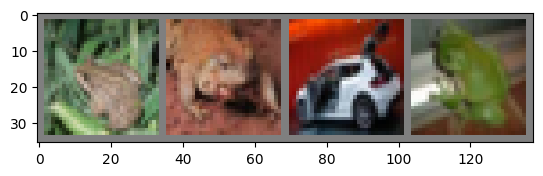

In [8]:
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_ , predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%7s' % classes[predicted[j]]for j in range(4)))

In [9]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 44.78%


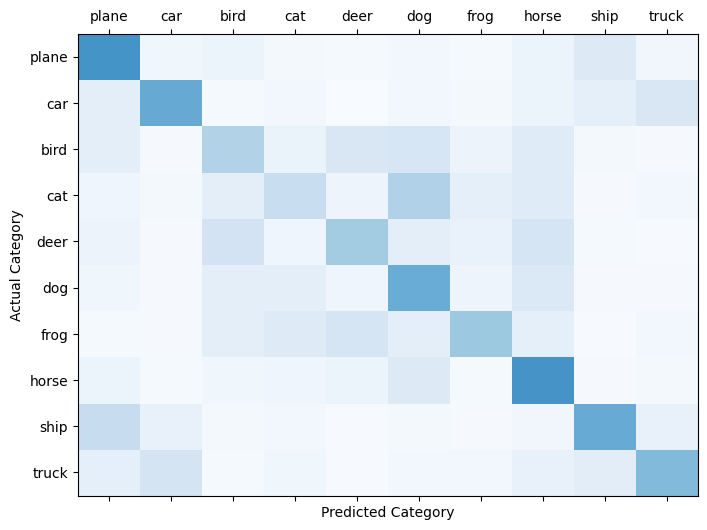

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

Bad results! 
##### Increasing Convolutional Filters
I will try to increase the number of filters in the convolutional layers and see if this improves the ability of the network to capture more complex features from the input images and the accuracy will improve.

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2) # Output shape: 32*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output shape: 32*16*16

        #Layer 2:
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1) # Output shape: 64*8*8
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output shape: 64*4*4

        #Layer 3:
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=3, padding=1) # Output shape: 128*1*1
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output shape: 128*1*1

        # Linear Layer
        self.fc = nn.Linear(128*1*1, 10)


    def forward(self, x):
        #Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        #Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        #Layer 3:
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Fully connected Layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return(x)
        
net = Net()


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[1, 12500] loss: 13.824
[2, 12500] loss: 11.659
[3, 12500] loss: 10.183
[4, 12500] loss: 9.320
[5, 12500] loss: 8.738
Finished Training
Model accuracy on 10000 test images: 51.29%


Accuracy has improved but still not good. 
##### Reducing the Kernel Sizes and Stride Values
I'll now try reducing the kernel sizes and stride values in the convolutional layers, aiming to better capture detailed and localized features in the images.

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) # Output shape: 32*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output shape: 32*16*16

        #Layer 2:
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Output shape: 64*16*16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output shape: 64*8*8

        #Layer 3:
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # Output shape: 128*8*8
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output shape: 128*4*4

        # Linear Layer
        self.fc = nn.Linear(128*4*4, 10)


    def forward(self, x):
        #Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        #Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        #Layer 3:
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Fully connected Layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return(x)
        
net = Net()


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[1, 12500] loss: 12.488
[2, 12500] loss: 9.668
[3, 12500] loss: 8.575
[4, 12500] loss: 7.853
[5, 12500] loss: 7.254
Finished Training
Model accuracy on 10000 test images: 58.95%


A certain improvement is evident!
##### Switching to Adam Optimizer
I will try to switch to Adam optimization, since Alon said he is the best option and Alon is always right.

In [19]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[1, 12500] loss: 7.915
[2, 12500] loss: 5.896
[3, 12500] loss: 5.233
[4, 12500] loss: 4.816
[5, 12500] loss: 4.519
Finished Training
Model accuracy on 10000 test images: 70.33%


Indeed Alon is always right!
##### Regularization
I will try different regularization methods: 

**L2 regularization-**
L2 regularization can improve a model's accuracy on new data by preventing overfitting, encouraging smaller weights, and thereby reducing the model's complexity. This results in a model that generalizes better and performs more consistently on unseen data.

In [20]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[1, 12500] loss: 7.789
[2, 12500] loss: 5.702
[3, 12500] loss: 5.115
[4, 12500] loss: 4.732
[5, 12500] loss: 4.462
Finished Training
Model accuracy on 10000 test images: 69.84%


No accuracy improvement. <br>
**Dropout-** Dropout is another regularization technique where randomly selected neurons are ignored during training. This prevents the network from becoming overly dependent on any single neuron and encourages the network to learn more robust features.
Lets try it!

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output shape: 32*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 32*16*16
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer

        # Layer 2:
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output shape: 64*16*16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 64*8*8
        self.dropout2 = nn.Dropout(0.5)  # Another dropout layer

        # Layer 3:
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output shape: 128*8*8
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 128*4*4
        self.dropout3 = nn.Dropout(0.5)  # Another dropout before 

        # Linear Layer
        self.fc = nn.Linear(128*4*4, 10)

    def forward(self, x):
        # Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)  # Apply dropout

        # Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)  # Apply dropout
        
        # Layer 3:
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)  # Apply dropout

        # Fully connected Layer
        x = x.view(x.size(0), -1)  # Flattening to shape of (batch size, 128*4*4)
        x = self.fc(x)

        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[1, 12500] loss: 9.901
[2, 12500] loss: 9.058
[3, 12500] loss: 9.001
[4, 12500] loss: 8.943
[5, 12500] loss: 8.932
Finished Training
Model accuracy on 10000 test images: 49.60%


The accuracy has not improved here either...
##### Adjusting the batch size
Adjusting the batch size can impact model accuracy as it affects gradient estimation and generalization; smaller batches may introduce beneficial noise in gradient updates, aiding in escaping local minima, while larger batches offer more stable but potentially less exploratory updates. The optimal batch size balances learning dynamics and computational efficiency, and its impact can vary depending on the specific characteristics of the dataset and model architecture. <br>

**Lower batch size:**


In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output shape: 32*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 32*16*16

        # Layer 2:
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output shape: 64*16*16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 64*8*8

        # Layer 3:
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output shape: 128*8*8
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 128*4*4

        # Linear Layer
        self.fc = nn.Linear(128*4*4, 10)

    def forward(self, x):
        # Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Layer 3:
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Fully connected Layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Files already downloaded and verified
Files already downloaded and verified
[1, 25000] loss: 16.773
[2, 25000] loss: 13.069
[4, 25000] loss: 11.374
[5, 25000] loss: 11.035
Finished Training
Model accuracy on 10000 test images: 66.43%


**Higher batch size:**

In [25]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Files already downloaded and verified
Files already downloaded and verified
[1,  6250] loss: 3.904
[2,  6250] loss: 2.745
[3,  6250] loss: 2.357
[4,  6250] loss: 2.110
[5,  6250] loss: 1.927
Finished Training
Model accuracy on 10000 test images: 73.28%


Batch Size of 2: Smallest batch size led to higher loss values and a lower final accuracy. Smaller batches introduce more noise in the gradient estimates, which can sometimes help with finding better minima but also makes training less stable and can require more adjustments in learning rate or other hyperparameters.

Batch Size of 4: A moderate batch size showed improved performance over a batch size of 2, with lower loss values during training and a higher final accuracy. This suggests a balance between the noise beneficial for escaping local minima and the stability in gradient estimates.

Batch Size of 8: The largest batch size tested resulted in the lowest loss values and the highest final accuracy. Larger batches provide more accurate gradient estimates per update, leading to more stable and effective training. However, they also require more memory, and the benefits might diminish or even reverse beyond a certain size due to over-smoothing of the loss landscape.

These results highlight the importance of choosing an appropriate batch size for training neural networks. While larger batches can lead to faster convergence and better accuracy due to more stable gradient estimates, very large batches might not always be feasible due to memory constraints or could lead to diminished returns. On the other hand, very small batches might require careful tuning of the learning process but can be beneficial in certain scenarios, especially when computational resources are limited.

##### Adjusting Network Depth and Layer Configuration
I will try to deepen and flatten the layers of the network: <br>
**Flatten the layers:**

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output shape: 32*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 32*16*16

        # Layer 2:
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output shape: 64*16*16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 64*8*8

        # Linear Layer
        self.fc = nn.Linear(64*8*8, 10)

    def forward(self, x):
        # Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        

        # Fully connected Layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Files already downloaded and verified
Files already downloaded and verified
[1,  6250] loss: 3.855
[2,  6250] loss: 2.923
[3,  6250] loss: 2.564
[4,  6250] loss: 2.357
[5,  6250] loss: 2.203
Finished Training
Model accuracy on 10000 test images: 70.61%


 When flattening the mesh structure leads to a decrease in accuracy, it can be assumed that this is because the model loses spatial and structural information that is critical for making accurate predictions. This may results in a model that is less capable of distinguishing between features that are spatially complex or require understanding of the relationships between different parts of the input data.<br>
**Deepen the layers:**

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output shape: 32*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 32*16*16

        # Layer 2:
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output shape: 64*16*16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 64*8*8

        # Layer 3:
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output shape: 128*8*8
        self.relu3 = nn.ReLU()

        # Layer 4:
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # Output shape: 256*8*8
        self.relu4 = nn.ReLU()

        # Linear Layer
        self.fc = nn.Linear(256*8*8, 10)

    def forward(self, x):
        # Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Layer 3:
        x = self.conv3(x)
        x = self.relu3(x)

        # Layer 4:
        x = self.conv4(x)
        x = self.relu4(x)

        # Fully connected Layer
        x = x.view(x.size(0), -1) 
        x = self.fc(x)

        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[1,  6250] loss: 4.213
[2,  6250] loss: 3.000
[3,  6250] loss: 2.526
[4,  6250] loss: 2.196
[5,  6250] loss: 1.907
Finished Training
Model accuracy on 10000 test images: 69.51%


**Deepen the Linear Layer**

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output shape: 32*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 32*16*16

        # Layer 2:
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output shape: 64*16*16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 64*8*8

        # Layer 3:
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output shape: 128*8*8
        self.relu3 = nn.ReLU()

        # Layer 4:
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # Output shape: 256*8*8
        self.relu4 = nn.ReLU()

        # Linear Layer
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer to prevent overfitting
        self.fc1 = nn.Linear(256*8*8, 128,bias=True)  # First linear layer
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # last linear layer

    def forward(self, x):
        # Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Layer 3:
        x = self.conv3(x)
        x = self.relu3(x)

        # Layer 4:
        x = self.conv4(x)
        x = self.relu4(x)

        # Fully connected Layer
        x = x.view(x.size(0), -1)  
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)

        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[1,  6250] loss: 4.333
[2,  6250] loss: 3.180
[3,  6250] loss: 2.777
[4,  6250] loss: 2.535
[5,  6250] loss: 2.337
Finished Training
Model accuracy on 10000 test images: 70.62%


The training loss and model accuracy across different network architectures—original, flattened layers, deepened layers, and deepened linear layers—show slight variations in performance on the test dataset and not helpful! <br>
The observed differences could be attributed to how each architecture manipulates the spatial and abstract representation of features. Flattening the network may reduce its ability to capture complex hierarchies of features, limiting improvement in accuracy. Deepening the network, conversely, increases its capacity for feature representation but may also introduce challenges in training optimization or overfitting, slightly detracting from test accuracy. 

##### Exploring Different Learning Rate
**Lower Learning Rate:**

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output shape: 32*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 32*16*16

        # Layer 2:
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output shape: 64*16*16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 64*8*8

        # Layer 3:
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output shape: 128*8*8
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 128*4*4

        # Linear Layer
        self.fc = nn.Linear(128*4*4, 10)

    def forward(self, x):
        # Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Layer 3:
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Fully connected Layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[1,  6250] loss: 4.755
[2,  6250] loss: 3.764
[3,  6250] loss: 3.299
[4,  6250] loss: 2.972
[5,  6250] loss: 2.729
Finished Training
Model accuracy on 10000 test images: 67.30%


**Higher Learning Rate:**

In [15]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[1,  6250] loss: 7.209
[2,  6250] loss: 7.471
[3,  6250] loss: 6.481
[4,  6250] loss: 6.345
[5,  6250] loss: 6.312
Finished Training
Model accuracy on 10000 test images: 24.90%


The results indicate a clear impact of the learning rate on the training dynamics and final model performance. <br>
The differences can be attributed to how the learning rate affects the model's ability to navigate the loss landscape. A moderate learning rate (0.001) allows the model to make steady progress towards the loss minimum, a low learning rate (0.0001) slows down this progress, possibly preventing convergence within a given timeframe, and a high learning rate (0.01) causes instability, preventing the model from settling into deeper minima. 
##### Best Score Model:

Files already downloaded and verified
Files already downloaded and verified
[1,  6250] loss: 3.921
[2,  6250] loss: 2.751
[3,  6250] loss: 2.363
[4,  6250] loss: 2.126
[5,  6250] loss: 1.921
Finished Training
Model accuracy on 10000 test images: 72.10%


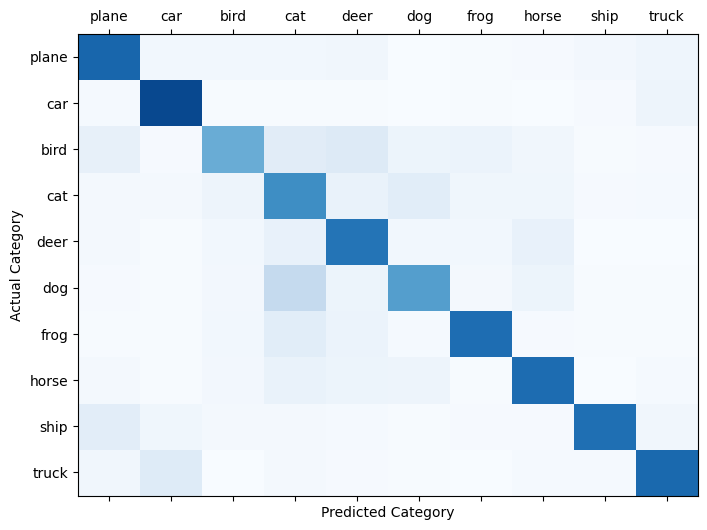

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Layer 1:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output shape: 32*32*32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 32*16*16

        # Layer 2:
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output shape: 64*16*16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 64*8*8

        # Layer 3:
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output shape: 128*8*8
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: 128*4*4

        # Linear Layer
        self.fc = nn.Linear(128*4*4, 10)

    def forward(self, x):
        # Layer 1:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2:
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Layer 3:
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Fully connected Layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_network(net, criterion, optimizer, trainloader)

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

The confusion matrix suggests that the model is highly accurate in classifying 'planes' and 'cars', as indicated by the darker cells in these categories' diagonal. However, it struggles to distinguish 'birds', showing a lower accuracy for this class. Additionally, there's notable confusion between 'dogs' and 'cats', where the model frequently misclassifies one for the other.

**Although the results have not reached optimal levels, there is a notable improvement compared to the linear classifier's 50% accuracy...**

# Part 3: More Visualizations

## Saliency Maps
A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (3, H, W) then this gradient will also have shape (3, H, W); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

### PyTorch gather method
If `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,)` containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then `s.gather(1, y.view(-1, 1)).squeeze()` will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

In [17]:
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print('s', s)
    print('y', y)
    print('gather', s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

s tensor([[ 1.4990, -0.4441, -0.4370, -0.3654,  0.1350],
        [-1.9843, -0.4352,  0.8730,  0.3657,  1.0130],
        [-0.8591,  1.2252, -0.5668, -1.1631, -2.3593],
        [-1.0455, -0.0812, -0.0211,  1.2598,  0.1353]])
y tensor([1, 2, 1, 3])
gather tensor([-0.4441,  0.8730,  1.2252,  1.2598])


In [18]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A trained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Ensure the model is in evaluation mode
    model.eval()
    
    saliency = None
    # Make input tensor require gradient (.requires_grad_()...)
    X.requires_grad_()

    
    # Perform a forward pass through the model to get the scores
    scores = model(X)
    
    # Select the scores corresponding to the correct class for each image
    # Hint: You will need to use the gather method
    scores = scores.gather(1, y.view(-1, 1)).squeeze()
    
    # Perform a backward pass to compute gradients of the correct scores with respect to input images
    # Hint: during regular backprop, the value we start the backprop from is the value of the loss.
    #       Since we don't have a loss here, you can start from the value 1, for each score. 
    scores.backward(torch.ones_like(scores))
    
    # Compute the saliency map as the maximum absolute value of gradients across the color channels
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)
    
    return saliency

In [19]:
def show_saliency_maps(X, y, model, classes):

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X, y, model)
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].cpu().detach().mul_(torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)).add_(torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)).permute(1, 2, 0))
        plt.axis('off')
        plt.title(classes[labels[i]])

        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')

    plt.gcf().set_size_inches(12, 5)
    plt.show()


In [20]:
dataiter = iter(testloader)

GroundTruth:      cat    ship    ship   plane


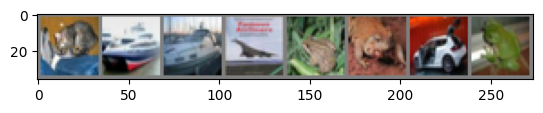

In [21]:
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(4)))

In [22]:
images.shape

torch.Size([8, 3, 32, 32])

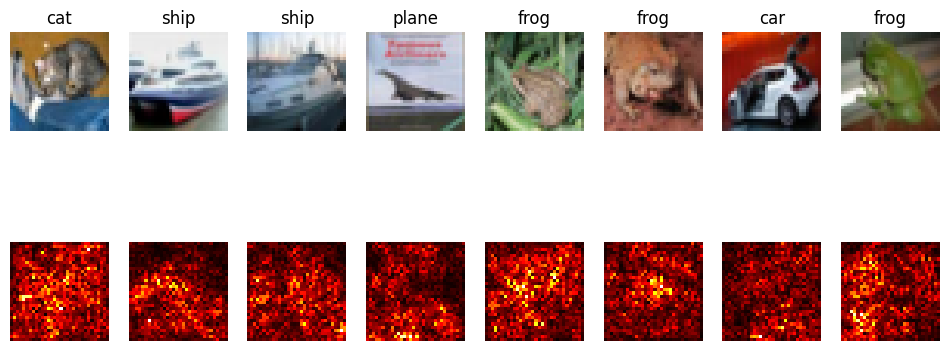

In [23]:
show_saliency_maps(images, labels, net, classes)

The results might be better visualized if we take a proper pre-trained network, like alexnet, which has better accuracy on a much more complex data and even has higher resolution images.

In [24]:
alexnet = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights)

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.
    Inputs:
    - num: Number of images to load (max of 25)
    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = 'imagenet_val_25.npz'
    f = np.load(imagenet_fn, allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

images, labels, class_names = load_imagenet_val(num=5)

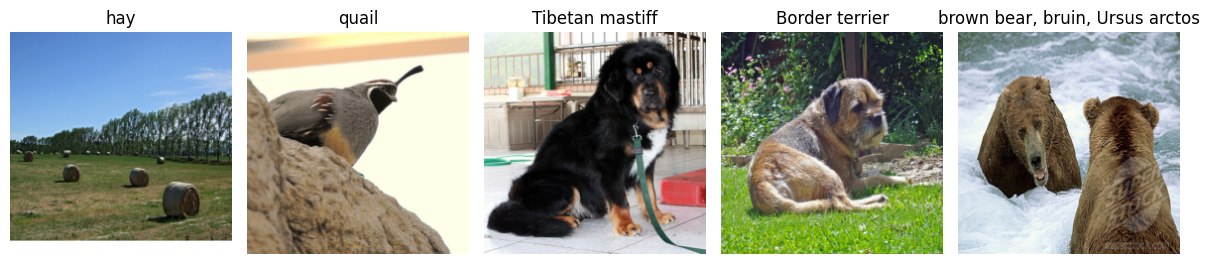

In [26]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [27]:
ALEXNET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
ALEXNET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [28]:
def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=ALEXNET_MEAN.tolist(),
                    std=ALEXNET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(img)

In [29]:
images_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in images], dim=0)
labels_tensor = torch.LongTensor(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


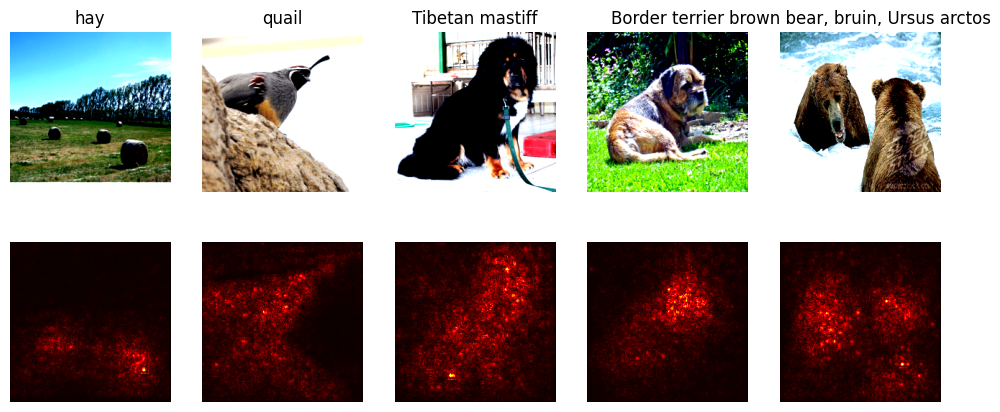

In [30]:
show_saliency_maps(images_tensor, labels_tensor, alexnet, class_names)

The saliency map visualization delineates defining features the neural network associates with each class. For instance, the body outline of the Tibetan Mastiff, the distinct crest of the quail, and the face shape of the Border Terrier are all highlighted, indicating their significant roles in the classification process. However, the bear's features appear less distinct in the saliency map, suggesting the network may have a less focused understanding of the characteristics that define this category.

# Thank You!